In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

In [2]:
_TINY = 1e-15


def _xyzto012(c):
    if c in 'xyz':
        return ord(c) - ord('x')
    else:
        raise AttributeError("vec3 instance has no attribute '%s'" % c)
        
def _args2tuple(funcname, args):
    narg = len(args)
    if narg == 0:
        data = 3*(0,)
    elif narg == 1:
        data = args[0]
        if len(data) != 3:
            raise TypeError('vec3.%s() takes sequence with 3 elements '
                            '(%d given),\n\t   when 1 argument is given' %
                             (funcname, len(data)))
    elif narg == 3:
        data = args
    else:
        raise TypeError('vec3.%s() takes 0, 1 or 3 arguments (%d given)' %
                        (funcname, narg))
    assert len(data) == 3
    try:
        return tuple(map(float, data))
    except (TypeError, ValueError):
        raise TypeError("vec3.%s() can't convert elements to float" % funcname)


class vec3(np.ndarray):
    def __new__(cls, *args):
        if len(args) == 1:
            if isinstance(args[0], vec3):
                return args[0].copy()
            if isinstance(args[0], np.matrix):
                return vec3(args[0].flatten().tolist()[0])
        data = _args2tuple('__new__', args)
        arr = np.array(data, dtype=np.float, copy=True)
        return np.ndarray.__new__(cls, shape=(3,), buffer=arr)
    
    def __repr__(self):
        return 'vec3' + repr(tuple(self))
    
    def __mul__(self, other):
        return np.dot(self, other)
    
    def __abs__(self):
        return math.sqrt(self * self)
    
    def __pow__(self, x):
        return (self * self) if x == 2 else pow(abs(self), x)
    
    def __eq__(self, other):
        return abs(self-other) < _TINY
    
    def __ne__(self, other):
        return not self == other
    
    def __getattr__(self, name):
        return self[_xyzto012(name)]
    
    def __setattr__(self, name, val):
        self[_xyzto012(name)] = val

    def elementwise_mul(self, other):

        return vec3(self[0] * other[0], self[1]*other[1], self[2]*other[2])
    
    def get_spherical(self):
        r = abs(self)
        if r < _TINY:
            theta = phi = 0.0
        else:
            x, y, z = self
            theta = math.acos(z/r)
            phi = math.atan2(y, x)
        
        return r, theta, phi
    
    def set_spherical(self, *args):
        r, theta, phi = _args2tuple('set_spherical', args)
        self[0] = r * math.sin(theta) * math.cos(phi);
        self[1] = r * math.sin(theta) * math.sin(phi);
        self[2] = r * math.cos(theta);
    
    def get_cylindrical(self):
        x, y, z = self
        rho = math.sqrt(x*x + y*y)
        phi = math.atan2(y, x)
        return rho, phi, z
    
    def set_cylindrical(self, *args):
        rho, phi, z = _args2tuple('set_cylindrical', args)
        self[0] = rho * math.cos(phi);
        self[1] = rho * math.sin(phi);
        self[2] = z


def cross(a, b):
    return vec3(np.cross(a, b))

In [16]:
class Sphere():

    def __init__(self, center, radius, color = None):

        self.center = center
        self.radius = radius
    
        if color is None:
            color = vec3(1,1,1)
        self.color = color


    def discriminant(self, light_loc, light_dir):

        relative_sphere_loc = (self.center - light_loc)
        discriminant = (relative_sphere_loc * light_dir)**2 - (relative_sphere_loc * relative_sphere_loc - self.radius**2)
        return discriminant


    # Returns a tuple: (bool intersected, min_distance, intersect_vector, normal_vector)
    def intersection(self, light_loc, light_dir):

        relative_sphere_loc = (self.center - light_loc)
        discriminant = (relative_sphere_loc * light_dir)**2 - (relative_sphere_loc * relative_sphere_loc - self.radius**2)
        # print("d1: ", discriminant)

        # Check for intersection (solving |rel_position + dir*t| = r for some t) 
        if discriminant > 0:

            # shortest distance
            t = (relative_sphere_loc * light_dir) - np.sqrt(discriminant)
            intersect_loc = light_loc + t*(light_dir)
            normal_to_sphere = (intersect_loc - self.center) / self.radius
            
            return (True, t, intersect_loc, normal_to_sphere, self.color)

        else: 

            return (False, np.inf, None, None)


class InfPlane():

    def __init__(self, center, color = None):

        self.normal = -center
        self.center = center

        if color is None:
            color = vec3(1,1,1)
            
        self.color = color


    def intersection(self, light_loc, light_dir):

        if self.normal * light_dir < 0:

            t = ((self.center - light_loc) * self.normal) /  (light_dir * self.normal)
            intersect_loc = light_loc + t*(light_dir)


            x_int = np.floor(intersect_loc[0] * 1)
            y_int = np.floor(intersect_loc[1] * 1)
            z_int = np.floor(intersect_loc[2] * 1)
            if (x_int + y_int + z_int) % 2 == 0:
                color = vec3(1,1,1)
            else:
                color = self.color * 0.5


            return (True, t, intersect_loc, self.normal, color)

        else:

            return (False, np.inf, None, None)

/var/folders/w0/0wlcf9nd71s7r2340_yg6njm0000gq/T/ipykernel_13126/3701830185.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = np.array(data, dtype=np.float, copy=True)


[ 0.  0. -1.]


Text(0.05, 0.85, 'Reflections: 0')

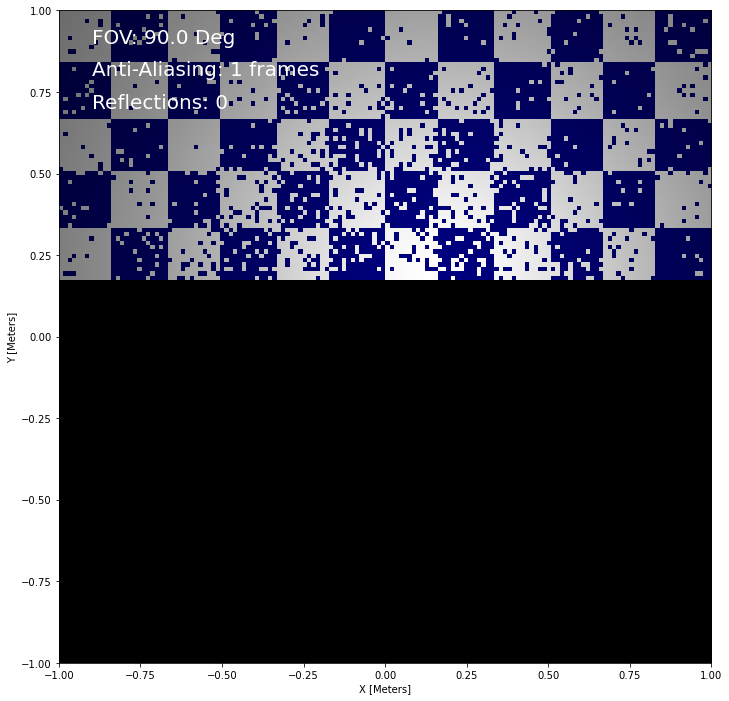

In [31]:
screen_center = vec3(0, 0, 0)
screen_height = 2*1
screen_width = 2*1
fov = np.pi / 2

frames = 1
pixel_jitter_std = 0.00 # fraction of width per pixel

camera_loc = vec3(0, 0, - screen_height / 2 / np.tan(fov / 2))
print(camera_loc)
distance_cutoff = 999999


pixels_x = 150
pixels_y = 150
image = np.zeros((pixels_x, pixels_y, 3))



spheres = [Sphere(vec3(-1.75, 0, 4), 1), 
           Sphere(vec3(-1.75, 3, 4), 1),
           Sphere(vec3(-1.75, -3, 4), 1),
           Sphere(vec3(-1.75, 0, 7), 1), 
           Sphere(vec3(-1.75, 3, 7), 1),
           Sphere(vec3(-1.75, -3, 7), 1),
           
        #    Sphere(vec3(0.50, 0, 4), 0.25),
           ]

infinite_planes = [InfPlane(vec3(-2.75, 0, 0), color = vec3(1,0,0)),
                   InfPlane(vec3(0, 0, 5), color = vec3(0,0,1)),
                #     InfPlane(vec3(0, 5, 0), color = vec3(0,1,0)),
                #    InfPlane(vec3(0, -5, 0), color = vec3(0,1,0)),

                    ]
objects = [*spheres, *infinite_planes]

centers = [vec3(-1.75, 0, 4), vec3(-0.75, 0, 4), vec3(0.0,0, 4), vec3(.5, 0, 4)]
radii = [1, 0.75, .5, .25]

light = vec3(1, 1, 1)


width_per_pixel = screen_width / pixels_x
height_per_pixel = screen_height / pixels_y


def intersect_object(loc, dir):
    pass


for N in range(frames):

    # for each pixel, emit a ray
    for i in range(pixels_x):
        for j in range(pixels_y):
            
            pixel_loc = -vec3(-screen_width/2 + (i+0.5)*width_per_pixel, screen_height/2 - (j+0.5)*height_per_pixel, 0)
            pixel_loc += vec3(np.random.normal(scale = pixel_jitter_std) * width_per_pixel, np.random.normal(scale = pixel_jitter_std) * height_per_pixel, 0 )

            ray_vector = pixel_loc - camera_loc
            ray_dir = ray_vector / abs(ray_vector)



            min_distance = np.inf
            best_intersection = None
            best_object = None
            for obj in objects:
                intersect_data = obj.intersection(pixel_loc, ray_dir)
                if intersect_data[1] < min_distance:
                    min_distance = intersect_data[1]
                    best_intersection = np.copy(intersect_data)
                    best_object = obj
          


            if min_distance < distance_cutoff:
                intersect_loc = best_intersection[2]
                normal_to_sphere = (best_intersection[3])
                color = best_intersection[4]
                light_source_direction = -(intersect_loc - light) / abs((intersect_loc - light))
                costheta = normal_to_sphere * light_source_direction / (abs(normal_to_sphere)) / (abs(light_source_direction))

                shadow = 1.0
                for obj in objects:
                    if not obj == best_object:
                        if obj.intersection(intersect_loc, light_source_direction)[0]:
                            shadow = 0
                            break


                # # Checkerboard
                # shade = 1.0
                # if best_object == infinite_plane:
                #     x_int = np.floor(intersect_loc[0] * 1)
                #     y_int = np.floor(intersect_loc[1] * 1)
                #     z_int = np.floor(intersect_loc[2] * 1)
                #     if (x_int + y_int + z_int) % 2 == 0:
                #         shade = 0.5


                image[i, j] += max(costheta,0) * shadow * color
                # if image[i,j] >  0:
                    # print(pixel_loc, t, intersect_loc, normal_to_sphere, light_source_direction)



image = image / frames       



fig, ax = plt.subplots(figsize=(12, 12))

pixel_plot = plt.imshow(image, interpolation='nearest', extent=(-1, 1, -1, 1), norm = matplotlib.colors.Normalize(vmin=0, vmax=1))
plt.xlabel("X [Meters]")
plt.ylabel("Y [Meters]")
# plt.title("FOV: 90 Deg, Fully Diffuse, Light at (2,2,1) Meters")
plt.text(0.05, 1.00 - 0.05*1, f"FOV: {fov * 180.0 / np.pi} Deg", color = "white", fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.05, 1.00 - 0.05*2, f"Anti-Aliasing: {frames} frames", color = "white", fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.05, 1.00 - 0.05*3, f"Reflections: {0}", color = "white", fontsize = 20, transform = plt.gca().transAxes,)
# for n in range(len(centers)):
#     plt.text(0.05, 1.00 - 0.05*(4+n), f"Sphere: {centers[n]}, R: {radii[n]}; 100% Diffuse", color = "white", fontsize = 20, transform = plt.gca().transAxes,)
